In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
#import Quantum_RR_2D as qrr
import schrodinger_2D as qrr
from datetime import datetime 
import scipy.fft as spfft

In [2]:
#Constats in the units such that mass is in atomic mass unit (amu), 
#time is in micro seconds, distances are in micrometers. We call these notebook units
kB = 1.38064852e-23 #Boltzman's Constant
UK = (60e-6) #Trap depth in kelvin
U = kB*UK/(1.66e-27) #In energy unists converted to notebook units
hb = 6.62607004e-34*1e6/(2*np.pi*1.66e-27) #Plank's constant
wtrap = 2 #Gaussian trap wasit in micrometers
mK = 41 # mass of atom in amu
lm = 0.790 #wavelength of light forming the gaussian trap in micrometers
#rmax = 3 #maximum distance for lattice in radial direction
#Nr = 2000 # number of lattice points in radial direction
g = 9.806/1e6;#acceleration due to gravity in notebook units

In [3]:
def Vfun(X, Y, params):
        """
        This function returns the potential energies for a gaussian beam in 2D.
        
        Inputs
        ------
        X: np.array
            np.array of the X axis
        Y: np.array
            np.array of the Y axis
        params: list
            list of parameters for the potential energy function
        
        Returns
        -------
        V: np.array
            np.array of the potential energy of the 2D gaussian beam
        """
        Nx = len(X)
        Ny = len(Y)
        M = Nx * Ny
        V = np.zeros((Nx,Ny))
        vindex = 0
        w0 = params[1]
        l  = params[2]
        for i in range(Nx):
            for j in range(Ny):
                rsq = X[i]**2+Y[j]**2
                V[i,j] = -params[0]*np.exp(-2*rsq/(w0**2))-mK*g*Y[j]                              
        return V

In [4]:
#2D spatial grid to consider for the wavefunctions
samplerate = 1000 # Number of points along one direction
xlim = 35
ylim = 35
xarray = np.arange(-xlim,xlim,2*xlim/samplerate)
yarray = np.arange(-ylim,ylim,2*ylim/samplerate)

#Get the corresponsinding wavevector values
karaysq = qrr.get_k_array(xarray,yarray,samplerate)

xs, ys = np.meshgrid(xarray, yarray, sparse=True)

In [5]:
#Load eigenvalues and eigenfunctions data.
evals = np.load('Simulation_data/2D_evals_60uK.npy')
evts = np.load('Simulation_data/2D_evecs_60uK.npy')
xlist = np.load('Simulation_data/2D_xlist_60uK.npy')
ylist = np.load('Simulation_data/2D_ylist_60uK.npy')

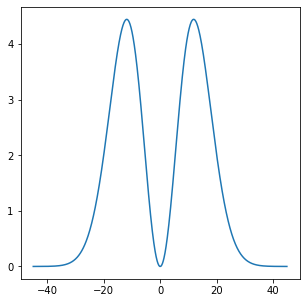

 Time elapsed (hh:mm:ss.ms) 0:00:10.198475


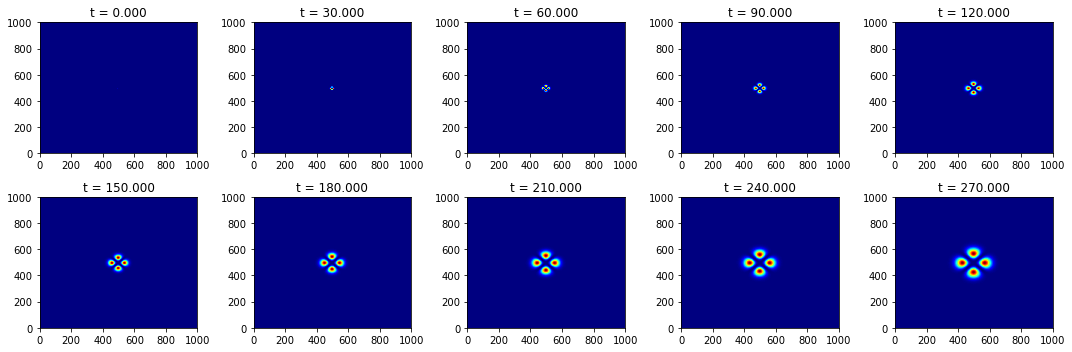

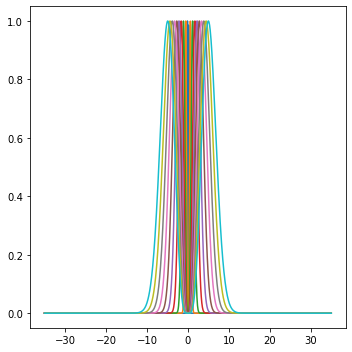

In [7]:
timevars = [0,300,5] #[t0,tf,dt]. Times for evolution

start_time = datetime.now()

#Interpolate the wavefunction and get wavefunction at xarray and yarray
psi_target1 = qrr.get_extrapolated_wfn(evts[5],xlist,ylist,xs,ys)

#Look at the fourier transform of the wavefunction
psifft =  spfft.fftn(psi_target1,axes = [0,1])
freqx = spfft.fftfreq(xarray.shape[0], d=1/samplerate)*(2*np.pi)
freqx = np.sort(freqx/(-2*xarray[0]))
fig = plt.figure(figsize = [5,5])
plt.plot(freqx,np.abs(spfft.fftshift(psifft)[:,int(samplerate/2)]))
plt.show()

#Potential free evolution of the wavfunction, mimicking the release of atoms from the trap. 
tarray,psit = qrr.schrodinger2D_kspace_TD(psifft,karaysq,timevars, hb, mK)
time_elapsed = datetime.now() - start_time 
print('\r','Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed)) 

#Visualize the wavefunction evolution
ntot = 10 #total number to show
fig = plt.figure(figsize = [15,5])
for n in range(ntot):
    psi =psit[6*n]  
    PSI = np.abs(psi)**2
    plt.subplot(2, int(ntot / 2), n + 1)    
    plt.pcolormesh(PSI, cmap = "jet")
    plt.title('t = %.3f'%(tarray[6*n]))
plt.tight_layout()
plt.show()
fig = plt.figure(figsize = [5,5])

#Wavefunction change along x axis
for n in range(ntot):
    psi =psit[6*n]  
    PSI = np.abs(psi)**2
    PSI =PSI/np.max(PSI[int(samplerate/2),:])
    plt.plot(xarray,PSI[int(samplerate/2),:])
plt.tight_layout()
plt.show()

 Time elapsed (hh:mm:ss.ms) 0:01:26.781291


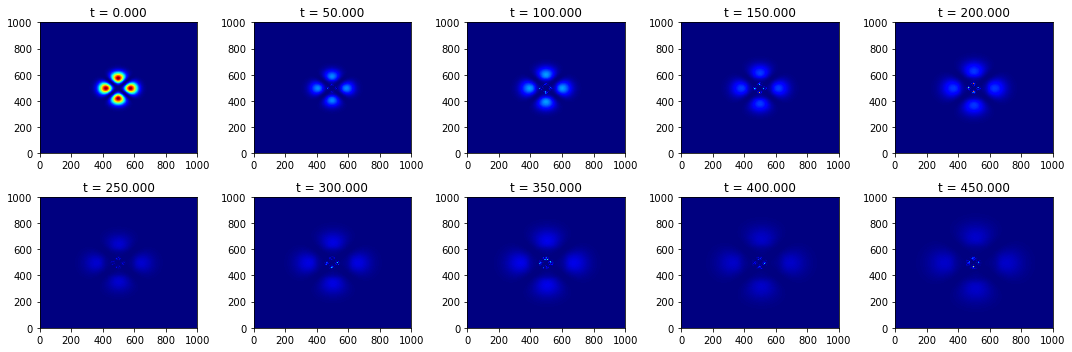

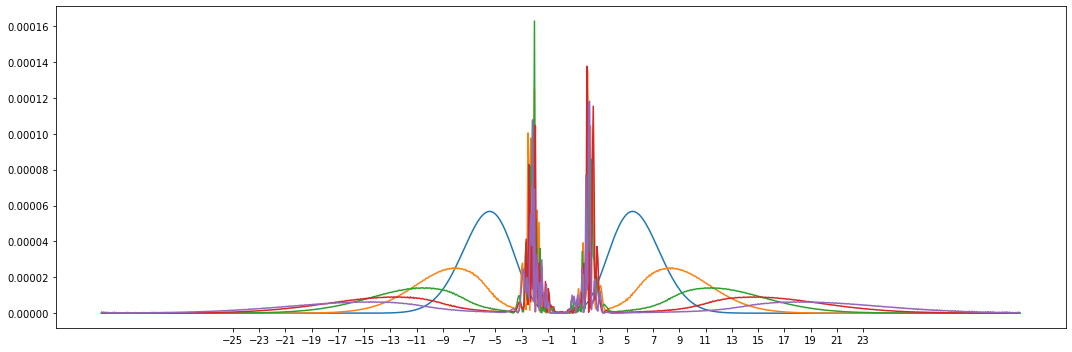

In [8]:
#Evolution of the wavfunction with potential switched on, mimicking the recapture of atoms from the trap. 

psi0 = psit[-1]

timevars1 = [0,1150,2,50] #[t0,tf,dt]
params = [U,wtrap,lm]
start_time = datetime.now()
tarray1,psit1 = qrr.Splitstep_2D_TD(xarray,yarray,psi0,timevars1,Vfun, params,karaysq, hb, mK)
time_elapsed = datetime.now() - start_time 
print('\r','Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed)) 

#Visualize the wavefunction evolution
ntot = 10 #total number to show
fig = plt.figure(figsize = [15,5])
for n in range(ntot):
    psi =psit1[n]  
    psi = psi.reshape((samplerate,samplerate))
    PSI = np.abs(psi)**2
    plt.subplot(2, int(ntot / 2), n + 1)    
    plt.pcolormesh(PSI, cmap = "jet")
    plt.title('t = %.3f'%(tarray1[n]))
plt.tight_layout()
plt.show()
fig = plt.figure(figsize = [15,5])
for n in range(5):
    psi =psit1[3*n]  
    psi = psi.reshape((samplerate,samplerate))
    PSI = np.abs(psi)**2
    plt.plot(xarray,PSI[int(samplerate/2),:])
plt.xticks(np.arange(-25,25,2))
plt.tight_layout()
plt.show()

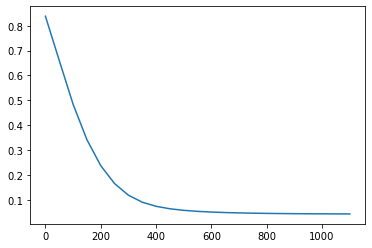

In [9]:

#Calculating the part of wavefunction which remains in the trap, 
#i.e in the range[- 2*wtrap, 2*wtrap]
#This is to check when the wavefunction statbilizes
prob_change = []
for i in range(tarray1.shape[0]):
    psi =psit1[i]  
    xtraprange = int((2*wtrap/xlim)*samplerate)
    xm = int(samplerate/2)-xtraprange
    xp = int(samplerate/2)+xtraprange
    prob_change.append(np.sum(np.abs(psi[xm:xp,xm:xp])**2))
prob_change = np.array(prob_change)
plt.plot(tarray1,prob_change)
plt.show()

In [10]:
#Calculate the probability of the atom recapture at different recapture times. 

timevars1 = [0,1100,2,500] #[t0,tf,dt]
prob_RR = []
start_time = datetime.now()

for j in range(tarray.shape[0]):
    psi0 = psit[j]
    tarray1,psit1 = qrr.Splitstep_2D_TD(xarray,yarray,psi0,timevars1,Vfun, params,karaysq, hb, mK)
    psi =psit1[-1]  
    prob_RR.append(np.sum(np.abs(psi[xm:xp,xm:xp])**2))
prob_RR = np.array(prob_RR)
time_elapsed = datetime.now() - start_time 
print('\r','Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed)) 

 Time elapsed (hh:mm:ss.ms) 1:26:52.679170


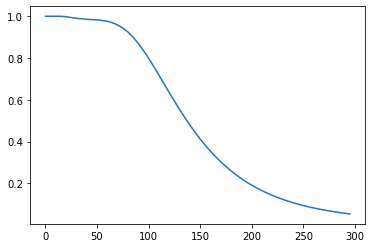

In [11]:
# Probability of recapture
plt.plot(tarray,prob_RR)
plt.show()